## Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
from pathlib import Path
import os
from typing import Tuple , Dict , List
from PIL import Image
from torchvision import transforms

## Setting up the paths

In [3]:
root_dir = Path("/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset")
train_dir = root_dir / "Train"
test_dir = root_dir / "Test"
val_dir = root_dir / "Validation"

In [4]:
train_dir 

PosixPath('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train')

In [5]:
def find_classes(directory):
    classes = [entity.name for entity in os.scandir(directory)]
    class_to_idx = {name: i for i , name in enumerate(classes) }
    return classes, class_to_idx

In [6]:
classes , class_to_idx = find_classes(train_dir)

## Plotting function for Image

In [95]:
def plot_transformed_images(image_paths, transform, n=3, random_seed=42):
    random_image_paths = random.sample(image_paths, k=n)
    for random_image in random_image_paths:
        with Image.open(random_image) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title("Original Image")
            ax[0].axis = False

            ax[1].imshow(transform(f).permute(1, 2, 0))
            ax[1].set_title("Transformed Image")
            ax[1].axis = False
            fig.suptitle(f'Class : {random_image.parent.stem}')


In [97]:
image_path_list = list(train_dir.glob("*/*/*.jpg"))

## Dataset Creation

In [7]:
class LoadDataset(Dataset):
    def __init__(self, directory, transform = None):
        super().__init__()
        self.paths = list(Path(directory).glob("*/*.png"))
        self.class_names, self.class_to_idx = find_classes(directory)
        self.transform = transform 
    def load_image(self , index:int):
        return Image.open(self.paths[index])

    def __len__(self)->int:
        return len(self.paths)

    def __getitem__(self, index:int)->Tuple[torch.Tensor , int]:
        image = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_to_idx = self.class_to_idx[class_name]
        if self.transform:
            image = self.transform(image)
        return image, class_to_idx
        

## Transforms

In [8]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transforms = transforms.Compose([
    transforms.Resize(size=  (224, 224)),
    transforms.ToTensor()
])

In [99]:
import random

## DataLoaders

In [9]:
train_dataset = LoadDataset(train_dir , transform=train_transforms)
test_dataset = LoadDataset(test_dir , transform=test_transforms)

In [10]:
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(), shuffle=True )
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(), shuffle=False )

In [11]:
len(train_dataset), len(test_dataset)

(10000, 992)

In [12]:
image , label = next(iter(train_dataloader))

In [13]:
image[0].shape

torch.Size([3, 224, 224])

In [14]:
image[0].permute(1, 2, 0).numpy().shape

(224, 224, 3)

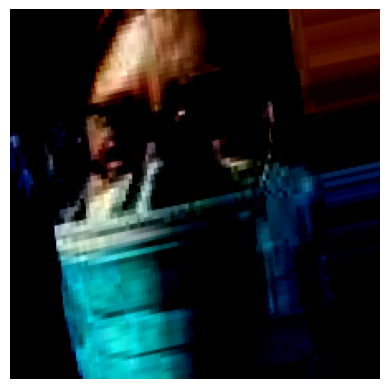

In [15]:
plt.imshow(image[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

### We set the seed for Reproducibility

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [18]:
import torchvision.models as models

# Simple Model Without Vision Transformer
## Reason for using the Complex Vision Transformer is to utlize and demonstrate the power of Quantization in next session

In [19]:
class MaskDetectionModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units *56 *56,
                      out_features=output_shape),
            nn.Sigmoid()
        )

    def forward(self, X: torch.Tensor):
        x = self.conv_block1(X)
#         x = self.conv_block2(x)
        x = self.classifier(x)
        return x


In [20]:
model = MaskDetectionModel(input_shape = 3 ,hidden_units = 128 ,output_shape = 1).to(device)

# Vision Transformer Model

In [21]:
from transformers import ViTImageProcessor, ViTModel

2024-04-30 17:05:36.464788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 17:05:36.464936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 17:05:36.589494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
from PIL import Image

In [23]:
from transformers import ViTFeatureExtractor,ViTImageProcessor, ViTModel
base_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [24]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [25]:
torch.cuda.manual_seed(SEED)

## Defining the VIT architecture

In [26]:
import torch.nn.functional as F

class CustomViTClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomViTClassifier, self).__init__()
        self.base_model = base_model
        self.num_classes = num_classes
        self.classifier = nn.Sequential(nn.Linear(base_model.config.hidden_size, num_classes),
                                       nn.Sigmoid())
        
    def forward(self, x):
        # Forward pass through the base model
        base_output = self.base_model(x)
        
        # Extract the tensor from BaseModelOutputWithPooling
        pooled_output = base_output.last_hidden_state[:, 0]
        
        # Forward pass through the classifier
        logits = self.classifier(pooled_output)
        
        return logits


In [27]:
model = CustomViTClassifier(base_model,1).to(device)

In [28]:
model(torch.randn([1,3 , 224, 224]).to(device))

tensor([[0.5051]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [29]:
from torchinfo import summary

### Printing the Summary

In [30]:
summary(model , input_size = (BATCH_SIZE , 3 , 224 , 224))

Layer (type:depth-idx)                                  Output Shape              Param #
CustomViTClassifier                                     [64, 1]                   --
├─ViTModel: 1-1                                         [64, 768]                 --
│    └─ViTEmbeddings: 2-1                               [64, 197, 768]            152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [64, 196, 768]            590,592
│    │    └─Dropout: 3-2                                [64, 197, 768]            --
│    └─ViTEncoder: 2-2                                  [64, 197, 768]            --
│    │    └─ModuleList: 3-3                             --                        85,054,464
│    └─LayerNorm: 2-3                                   [64, 197, 768]            1,536
│    └─ViTPooler: 2-4                                   [64, 768]                 --
│    │    └─Linear: 3-4                                 [64, 768]                 590,592
│    │    └─Tanh: 3-5             

### Training Steps Function

In [31]:
def train_model(model, optimizer, loss_fn, train_dataloader, device=device):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device).unsqueeze(dim=1).float()
        logits = model(X)
        loss = loss_fn(logits, y)
        acc = (logits.round() == y).sum().item() / len(logits.argmax(dim=1))
        
        train_loss += loss.item()
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    return train_loss, train_acc


### Testing Steps Function

In [32]:
def test_model(model, test_dataloader, loss_fn, device=device):
    model.eval()
    test_acc = 0
    test_loss  = 0
    
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X = X.to(device)
            y = y.to(device).unsqueeze(dim=1).float()
            logits = model(X)
            loss = loss_fn(logits, y)
            acc = (logits.round() == y).sum().item() / len(logits.argmax(dim=1))
            
            test_loss += loss.item()
            test_acc += acc
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    return test_loss, test_acc


In [33]:
from tqdm.auto import tqdm

### Complete Train Function

In [34]:
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=5, device=device):
    """This function is used to train the model"""
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_model(model, optimizer, loss_fn, train_dataloader, device=device)
        test_loss, test_acc = test_model(model, test_dataloader, loss_fn, device=device)
        
        print(f'Epoch: {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
    
    return results


In [35]:
from timeit import default_timer as timer

## Training

In [36]:

EPOCHS = 10
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
loss_fn = nn.BCELoss()
start_time = timer()
results = train(model , train_dataloader , test_dataloader, loss_fn , optimizer , EPOCHS, device = device)
end_time = timer()
print(f'Total Training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.19913789902214601, Train Accuracy: 0.9255573248407644, Test Loss: 0.7142553764861077, Test Accuracy: 0.55859375
Epoch: 1, Train Loss: 0.0748571766641252, Train Accuracy: 0.9756170382165605, Test Loss: 0.392065417021513, Test Accuracy: 0.82421875
Epoch: 2, Train Loss: 0.06980052989296567, Train Accuracy: 0.9757165605095541, Test Loss: 1.5629137704672758, Test Accuracy: 0.5576171875
Epoch: 3, Train Loss: 0.05299561735017189, Train Accuracy: 0.9825835987261147, Test Loss: 0.21484293090179563, Test Accuracy: 0.9345703125
Epoch: 4, Train Loss: 0.039885369961811405, Train Accuracy: 0.9866640127388535, Test Loss: 0.22075139143998967, Test Accuracy: 0.9541015625
Epoch: 5, Train Loss: 0.04536961937533798, Train Accuracy: 0.9860668789808917, Test Loss: 0.15360908897127956, Test Accuracy: 0.955078125
Epoch: 6, Train Loss: 0.02722059457509476, Train Accuracy: 0.9912420382165605, Test Loss: 0.18615142698399723, Test Accuracy: 0.947265625
Epoch: 7, Train Loss: 0.0307130464879

## Lets plot the Error

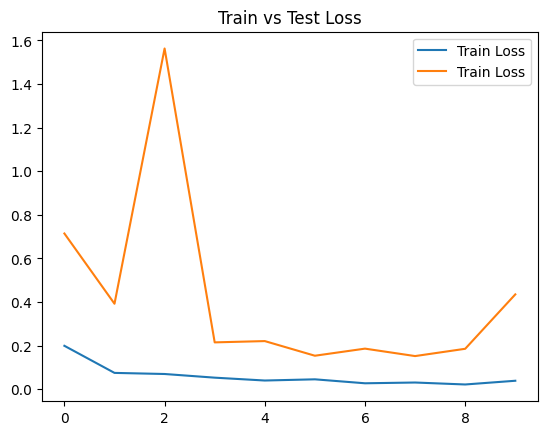

In [41]:
plt.plot(results['train_loss'], label="Train Loss")
plt.plot(results['test_loss'], label="Train Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()

## Lets plot the accuracy

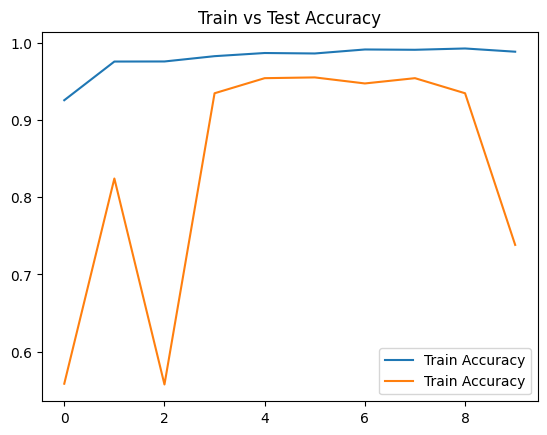

In [42]:
plt.plot(results['train_acc'], label="Train Accuracy")
plt.plot(results['test_acc'], label="Train Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.show()

In [43]:
model_path = "/kaggle/working/mask_detection_model.pth"

# Save the model
torch.save(model.state_dict(), model_path)

## Saving the model

In [40]:
torch.save(model, model_path)

In [44]:
import os

def get_file_size_mb(filename):
    # Check if the file exists
    if not os.path.exists(filename):
        return f"File '{filename}' does not exist."
    
    # Get the file size in bytes
    size_bytes = os.path.getsize(filename)
    
    # Convert bytes to megabytes
    size_mb = size_bytes / (1024 * 1024)
    
    return size_mb

In [50]:
print(f'{get_file_size_mb("/kaggle/working/mask_detection_model.pth")} MB')

329.6351509094238 MB


# ONNX Format

In [74]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.4 MB/s eta 0:00:00


In [76]:
import onnxruntime

In [88]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export the model to ONNX format
output_onnx = "/kaggle/working/model.onnx"
torch.onnx.export(model, dummy_input, output_onnx, opset_version = 10,
                  input_names=["image"],
                  output_names=["Linear"])

### Inference using ONNX model

In [77]:
session = onnxruntime.InferenceSession("model.onnx")

In [83]:
onnx_output = session.run(["Linear"], {"image": np.random.randn(1, 3, 224, 224).astype(np.float32)})

In [84]:
onnx_output

[array([[0.9831357]], dtype=float32)]

## Now lets see how to convert ONNX format into the tensorflow model

In [86]:
!sudo apt-get -y update
!sudo apt-get -y install python3-pip
!sudo apt-get -y install python-is-python3
!wget https://github.com/PINTO0309/onnx2tf/releases/download/1.16.31/flatc.tar.gz \
  && tar -zxvf flatc.tar.gz \
  && sudo chmod +x flatc \
  && sudo mv flatc /usr/bin/
!pip install -U pip \
  && pip install tensorflow==2.16.1 \
  && pip install -U onnx==1.15.0 \
  && python -m pip install onnx_graphsurgeon \
        --index-url https://pypi.ngc.nvidia.com \
  && pip install -U onnxruntime==1.17.1 \
  && pip install -U onnxsim==0.4.33 \
  && pip install -U simple_onnx_processing_tools \
  && pip install -U onnx2tf \
  && pip install -U protobuf==3.20.3 \
  && pip install -U h5py==3.11.0 \
  && pip install -U psutil==5.9.5 \
  && pip install -U ml_dtypes==0.3.2 \
  && pip install -U tf-keras~=2.16

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1515 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:5 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]   
Get:6 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:8 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [21.0 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [631 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1201 kB]
Hit:12 http://archive.ubuntu.com/ubuntu focal-backport

In [87]:
from tensorflow.lite.python import interpreter as tflite_interpreter

In [90]:
import onnx2tf # !pip install onnx2tf # if not installed

### You can check further here: https://github.com/PINTO0309/onnx2tf

In [91]:
onnx2tf.convert(
    input_onnx_file_path="/kaggle/working/model.onnx",
    output_folder_path="/kaggle/working/model.tf",
    copy_onnx_input_output_names_to_tflite=True,
    non_verbose=True,
)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 189, Total Ops 703, % non-converted = 26.88 %
 * 189 ARITH ops

- arith.constant:  189 occurrences  (f32: 178, i32: 11)



  (f32: 111)
  (f32: 24)
  (f32: 1)
  (f32: 1)
  (f32: 49)
  (f32: 1)
  (f32: 12)
  (f32: 1)
  (f32: 50)
  (f32: 87)

  (f32: 49)
  (f32: 25)
  (f32: 12)
  (f32: 12)
  (f32: 25)
  (f32: 50)
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 189, Total Ops 881, % non-converted = 21.45 %
 * 189 ARITH ops

- arith.constant:  189 occurrences  (f16: 178, i32: 11)



  (f32: 111)
  (f32: 24)
  (f32: 1)
  (f32: 1)
  (f32: 178)
  (f32: 49)
  (f32: 1)
  (f32: 12)
  (f32: 1)
  (f32: 50)
  (f32: 87)

  (f32: 49)
  (f32: 25)
  (f32: 12)
  (f32: 12)
  (f32: 25)
  (f32: 50)


### Prediction with tensorflow , it shows the power of ONNX format 

In [94]:
interpreter = tf.lite.Interpreter(model_path="model.tf/model_float32.tflite")
tf_lite_model = interpreter.get_signature_runner()
inputs = {
  "image":np.random.randn(1, 224, 224, 3).astype(np.float32)
}
tf_lite_output = tf_lite_model(**inputs)
print("[TFLite] Model Predictions:", tf_lite_output)

[TFLite] Model Predictions: {'Linear': array([[0.99077106]], dtype=float32)}


## Now lets see a final thing whether these models predict correct on custom data

In [103]:
import requests
import numpy as np
from PIL import Image
import io

def download_resize_and_convert_to_numpy(url, target_size=(224, 224)):
    "Helper function to download the image and resize it so it should be ready for the model to use"
    # Send a GET request to the URL to fetch the image
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open the image using PIL
        image = Image.open(io.BytesIO(response.content))
        
        # Resize the image to the target size
        image_resized = image.resize(target_size)
        
        # Convert the resized image to a NumPy array
        image_array = np.array(image_resized)
        
        return image_array
    else:
        print("Failed to download image. Status code:", response.status_code)
        return None

In [104]:
# Example usage
url = "https://www.froedtert.com/sites/default/files/image/2020-11/how-to-wear-face-mask-right-way.jpg"  # Replace with the URL of the image you want to download
image_np = download_resize_and_convert_to_numpy(url)

# Check if the image was successfully downloaded, resized, and converted
if image_np is not None:
    print("Resized image shape:", image_np.shape)
else:
    print("Image download failed.")

Resized image shape: (224, 224, 3)


In [106]:
image_np.shape

(224, 224, 3)

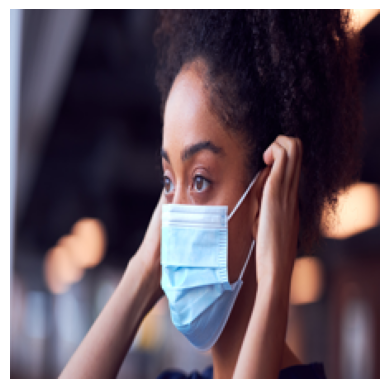

In [107]:
plt.imshow(image_np)
plt.axis("off")
plt.show()

In [114]:
onnx_output = session.run(["Linear"], {"image": np.transpose(np.expand_dims(image_np, axis=0).astype(np.float32), (0, 3, 1, 2))})


In [126]:
print(f"Prediction is: {classes[np.squeeze(np.round(onnx_output)).astype(int).item()]}")

Prediction is: WithMask
